# Codificação de arquivos e operações pontuais

## Convertendo imagem

Importando bibliotecas e definindo variávies.

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error

file_name = "VisaoTrab1.tiff"
file_name_no_extension = os.path.splitext(file_name)[0]

Abrindo o arquivo "VisaoTrab1.tiff".

In [2]:
img = cv2.imread(file_name)

Criando arquivos JPEG - 10, 50 e 90%

In [3]:
created_files = []
for quality in [10, 50, 90]:
    created_files += [f'{file_name_no_extension}_{quality}.jpg']
    cv2.imwrite(created_files[-1], img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])

Salvar imagem como TIFF - LZW.
Conforme descrito na documentação do OpenCV, versão 4.0.1 (a que é instalada pelo pip3), o padrão do TIFF não permite escolher o tipo de compressão.
https://docs.opencv.org/3.0-beta/modules/imgcodecs/doc/reading_and_writing_images.html#imwrite

Aparentemente está disponivel apenas na versão 4.1 que necessita ser baixada e compilada para então instalar na máquina.

In [4]:
created_files += [f'{file_name_no_extension}_LZW.tiff']
# cv2.imwrite(created_files[-1], img, [5])
# cv2.imwrite(created_files[-1], img, [int(cv2.TIFFTAG_COMPRESSION), 5])
cv2.imwrite(created_files[-1], img)

True

Agora analisando agora diferença nos arquivos, sendo:
* VisaoTrab1.tiff o arquivo original;
* VisaoTrab1_10.jpg o arquivo em JPEG com 10% da qualidade;
* VisaoTrab1_50.jpg o arquivo em JPEG com 50% da qualidade;
* VisaoTrab1_10.jpg o arquivo em JPEG com 90% da qualidade;
* VisaoTrab1_LZW.tiff o arquivo salvo utilizando o formato TIFF.

A coluna **Tamanho** está expressa em bytes, a coluna % indica o percentual do tamanho do arquivo em relação ao original, EQM indica a média do erro quadrático para os canais blue (**EQM(B)**), green (**EQM(G)**) e red (**EQM( R )**).

In [5]:
file_size = os.path.getsize(file_name)
created_files_sizes = [os.path.getsize(x) for x in created_files]

table_values = []
table_values += [(file_name, file_size, 100, 0, 0, 0)]

def get_channel(image, channel_number):
    channel_cn = np.zeros(image.shape[:2])
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            channel_cn[x, y] = image[x, y][channel_number]
    return channel_cn

original_channel = [get_channel(img, x) for x in range(3)]

# print(f"Tamanho do arquivo original ({file_name}): {file_size} bytes.")
for i in range(len(created_files)):
    img_temp = cv2.imread(created_files[i])
    temp_channel = [get_channel(img_temp, x) for x in range(3)]
    temp_size = os.path.getsize(created_files[i])
    table_values += [(created_files[i], temp_size, 100.0 * temp_size / file_size, 
        mean_squared_error(original_channel[0], temp_channel[0]),
        mean_squared_error(original_channel[1], temp_channel[1]),
        mean_squared_error(original_channel[2], temp_channel[2]))]

print(";".join(['    Nome do arquivo', ' Tamanho', '   %  ', 'EQM(B)', 'EQM(G)', 'EQM(R)']))
for x in table_values:
    print(f"{x[0]:19s};{x[1]:8d};{x[2]:6.2f};{x[3]:6.2f};{x[4]:6.2f};{x[5]:6.2f}")

print("\nNome do arquivo, tamanho do arquivo em bytes, percentual do tamanho do arquivo original, média do erro quadrático para os canais BGR")

    Nome do arquivo; Tamanho;   %  ;EQM(B);EQM(G);EQM(R)
VisaoTrab1.tiff    ;  786754;100.00;  0.00;  0.00;  0.00
VisaoTrab1_10.jpg  ;    6823;  0.87; 70.02; 38.63; 51.05
VisaoTrab1_50.jpg  ;   13226;  1.68; 11.03;  7.73; 10.07
VisaoTrab1_90.jpg  ;   35895;  4.56;  4.09;  2.80;  3.36
VisaoTrab1_LZW.tiff;  319636; 40.63;  0.00;  0.00;  0.00

Nome do arquivo, tamanho do arquivo em bytes, percentual do tamanho do arquivo original, média do erro quadrático para os canais BGR


Conforme podemos ver nos arquivos em JPEG, embora os fatores de qualidade sejam de 10, 50 e 90% o tamanho dos arquivos gerados é de ordem de grandeza no máximo de 4,56% do tamanho do arquivo original, isto se dá porque este formato utiliza compressão com perda de informação.
Pode-se notar também como a média do erro quadrático para os canais BGR diminui a medida que se aumenta a qualidade do JPEG.

Outro ponto interessante de se analisar é que o formato salvo em TIFF representa penas 40,63% do tamanho do arquivo original mas apresenta valor zero para a média do erro quadrático para todos os canais.

------
## Correção gama

Convertento a imagem para HSV.

In [6]:
img = cv2.imread(file_name)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

Vai ser utilizado um fator gamma menor do que 1 para aumentar o contraste das partes escuras da imagem.
A constante com o valor máximo para o canal V, conforme a documentação do OpenCV o valor máximo para o canal H (Hue) é de 255.

https://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html

In [7]:
gamma = 1.0/2.0
channel_max = 255.0

Separando o canal H na variável channel_v e convertendo para a escala de 1.0 e então aplicando operação gamma sobre todo o canal V.

In [8]:
channel_v = get_channel(hsv, 2) / channel_max
channel_v = channel_v ** gamma * channel_max

Salvando na matrix.

In [9]:
def set_channel(dst, src, channel_number, channel_min = 0, channel_max = 255):
    for x in range(dst.shape[0]):
        for y in range(dst.shape[1]):
            dst[x, y][channel_number] = int(max(min(src[x, y], channel_max), 0))

set_channel(hsv, channel_v, 2, 0, channel_max)
# for x in range(hsv.shape[0]):
#     for y in range(hsv.shape[1]):
#         hsv[x, y][0] = int(max(min(channel_v[x, y], channel_max), 0))

Convertendo imagem para BGR e salvando o arquivo.

In [10]:
img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
file_name_gamma = f'{file_name_no_extension}_{gamma:.2f}.tiff'
cv2.imwrite(file_name_gamma, img)

True

Fazendo o histograma.

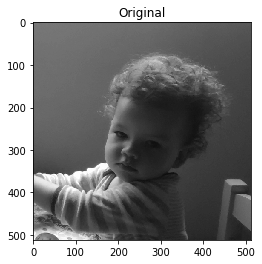

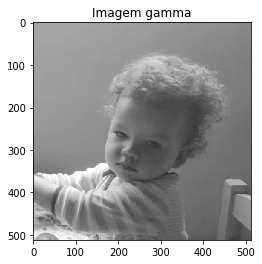

In [11]:
mpl.rc("savefig", dpi = 150)

image_titles = [(file_name, 'Original'), (file_name_gamma, 'Imagem gamma')]
images_rows_cols = []

for image_file_name, title in image_titles:
    img = cv2.imread(image_file_name, 0)
    rows, cols = img.shape
    images_rows_cols += [(img, rows, cols)]
    plt.imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    plt.title(title)
    plt.show()

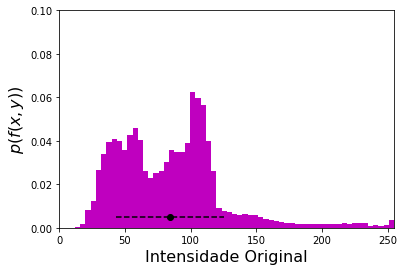


Media: 84.36
Desvio Padrao: 41.20
Primeiro valor não nulo no histograma: 2


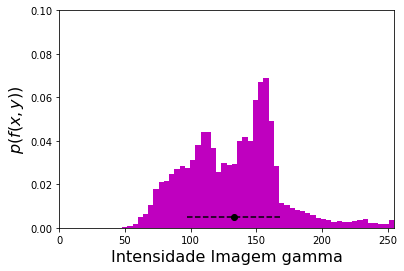


Media: 132.72
Desvio Padrao: 35.78
Primeiro valor não nulo no histograma: 10


In [12]:
for i in range(len(image_titles)):
    img, rows, cols = images_rows_cols[i]
    image_file_name, title = image_titles[i]

    hist, bins = np.histogram(img, range=(0, 255), bins=64)
    hist = hist / float(rows * cols)
    center = (bins[:-1] + bins[1:]) / 2
    first_not_zero = 0
    for i in range(len(hist)):
        first_not_zero = i
        if hist[i] > 0:
            break
    plt.bar(center, hist, align='center', color='m', width=4)
    plt.xlim([0, 255])
    plt.ylim([0, 0.1])
    plt.ylabel('$p(f(x,y))$', fontsize=16)
    plt.xlabel(f'Intensidade {title}', fontsize=16)
    m_y = 0.005
    m = np.mean(img)
    s = np.std(img)
    plt.plot(m, m_y , "ko")
    plt.plot([m - s, m + s], [m_y] * 2, "k--");
    plt.savefig(f'{os.path.splitext(image_file_name)[0]}_Hist.eps')
    plt.show()
    print(f'\nMedia: {np.mean(img):.2f}')
    print(f'Desvio Padrao: {np.std(img):.2f}')
    print(f'Primeiro valor não nulo no histograma: {first_not_zero}')

Ao utilizar um valor de gamma menor do que 1 estende-se o contraste da parte escura do histograma da imagem.
Conforme pode-se ver na comparação dos dois histogramas estes já são mais deslocados para os tons mais claros pois ao aumentar o contraste dos tons escuros os tons claros aumentaram sua frequência, ao aplicar a correção gamma podemos ver no resultado que a média é deslocada para a direita, de 84,36 para 132,72 e o desvio padrão cai de 41,20 para 35,78 o que confirma que os valores estão deslocados mais para a direita (valores mais claros, com maior luminância).